In [2]:
import random
import os
import numpy as np
import pandas as pd 
import seaborn as sns
from PIL import Image, ImageFilter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Function to read and flatten images
def read_process_and_flatten_image(file_path, target_size=(350, 350), blur_radius=2):
    with Image.open(file_path) as img:
        # Resize image
        img = img.resize(target_size, Image.ANTIALIAS)
        # Apply blurring
        img = img.filter(ImageFilter.GaussianBlur(blur_radius))
        # Normalize pixel values
        img_array = np.array(img) / 255.0
        # Flatten image
        img_array_flattened = img_array.flatten()
    return img_array_flattened

# Define the directories containing the images
train_dir = "train"

# Initialize lists to store file paths, pixel values, and labels
file_paths = []
pixels = []
labels = []

# Iterate over the train directory to collect file paths, pixel values, and labels
for file_name in os.listdir(train_dir)[:1100]:  # Selecting 1000 images for training
    file_path = os.path.join(train_dir, file_name)
    file_paths.append(file_path)
    image_pixels = read_process_and_flatten_image(file_path)
    pixels.append(image_pixels)
    labels.append(file_name.split('.')[0])  # Assuming label is before the first '.'

# Apply PCA to reduce dimensionality of the pixel values
pca = PCA(n_components=100)  # Adjust the number of components as needed
pixels_pca = pca.fit_transform(pixels)

# Create a DataFrame from the collected data
data = pd.DataFrame({'file_path': file_paths, 'pixels_pca': pixels_pca.tolist(), 'label': labels})

# Shuffle the DataFrame to randomize the order of the data
data = data.sample(frac=1).reset_index(drop=True)

/tmp/ipykernel_24/2172593509.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


In [4]:
data['label'].value_counts()

label
cat    560
dog    540
Name: count, dtype: int64

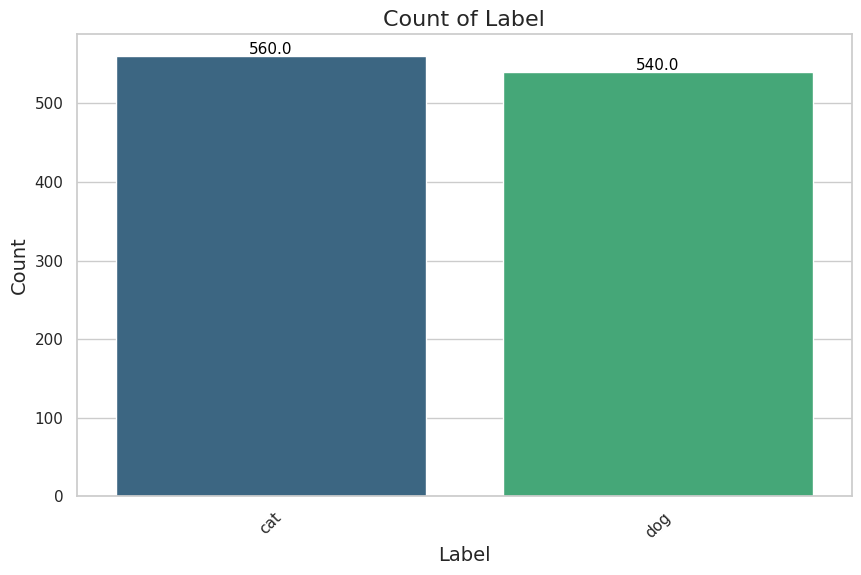

In [5]:
sns.set(style="whitegrid")  # Set the style
plt.figure(figsize=(10, 6))  # Set the figure size

custom_cmap = "viridis"  # You can choose any colormap you prefer

ax = sns.countplot(x='label', data=data, order=data['label'].value_counts().index, palette=custom_cmap)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Label', fontsize=16)

plt.xticks(rotation=45)

# Show plot
plt.show()

In [6]:
data.iloc[0]

file_path                   /kaggle/working/train/cat.11008.jpg
pixels_pca    [-11.569208489461426, -52.74821120456263, -75....
label                                                       cat
Name: 0, dtype: object

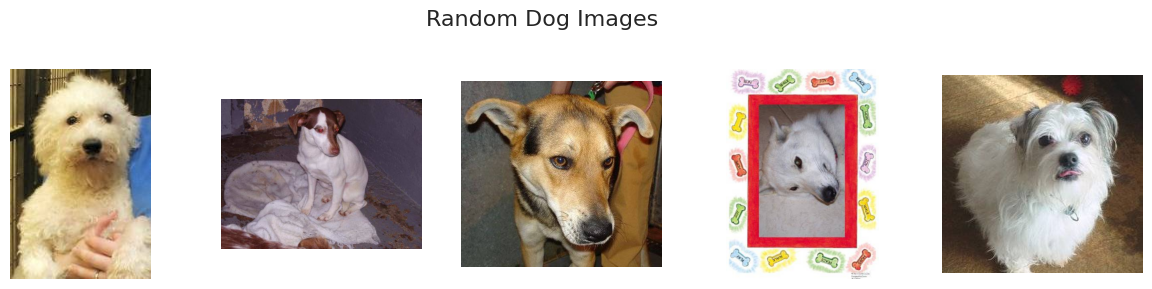

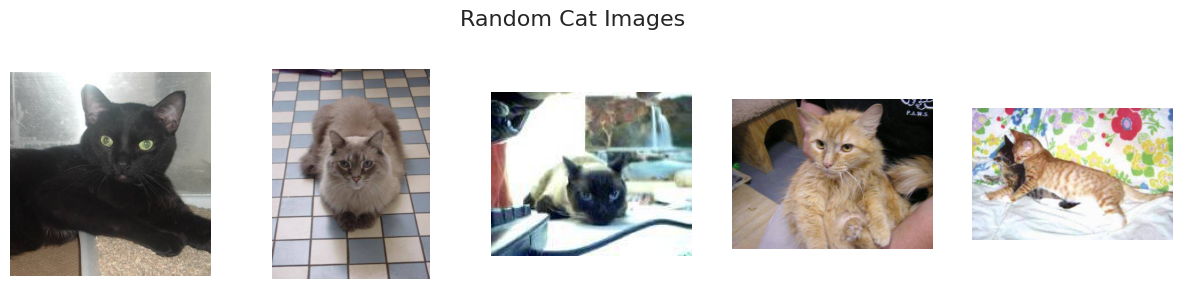

In [7]:
# Dog Image
plt.figure(figsize=(15, 6))
plt.suptitle('Random Dog Images', fontsize=16)
for i, img_file in enumerate(random.sample(list(data[data['label'] == 'dog']['file_path']), 5), 1):
    plt.subplot(2, 5, i)
    img = mpimg.imread(img_file)
    plt.imshow(img)
    plt.axis('off')


## Cat Image    
plt.figure(figsize=(15, 6))
plt.suptitle('Random Cat Images', fontsize=16)
for i, img_file in enumerate(random.sample(list(data[data['label'] == 'cat']['file_path']), 5), 1):
    img_path = os.path.join("/kaggle/working/train", img_file)
    plt.subplot(2, 5, i)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data['pixels_pca'].tolist(), data['label'], test_size=0.1, random_state=42)

In [9]:
print('Training data ', len(X_train))
print('Testing data ', len(X_test))

Training data  990
Testing data  110


In [10]:
# Standardize the pixel values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
pd.DataFrame(X_train_scaled)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.378497,0.353775,-0.724778,-0.097284,-1.900946,0.302828,0.260476,0.995682,-0.552447,-1.183942,...,-0.319466,-0.075765,1.781008,0.333441,0.719827,-0.479139,-2.063026,0.971122,0.382230,0.471470
1,-0.225796,0.372892,1.259782,1.306708,0.219979,0.259770,0.697216,2.656481,0.011697,0.365458,...,-1.436038,-1.356830,-0.893019,0.915708,-0.785611,0.121611,0.657740,1.039052,1.036441,0.401666
2,0.198623,0.237213,-1.645933,-0.477230,-1.429839,-0.506999,0.065118,-0.823034,0.692493,-0.467172,...,0.451266,1.032730,0.186841,0.622362,-1.135052,-0.449259,-0.147475,-0.470422,-0.004790,0.255092
3,-1.553617,-0.713580,-0.411641,-0.298013,-0.806665,-0.117871,0.031631,0.920504,-0.734279,0.523942,...,-0.529788,-0.743087,-0.149277,0.653206,0.309894,0.031466,-0.258629,1.019698,-1.110331,-0.431610
4,-0.378853,0.636049,-1.510908,-0.637479,0.521111,-0.141272,0.006211,0.062470,0.327564,-0.396476,...,0.541523,0.132286,0.317173,-0.958022,-0.355602,-0.398320,0.744149,0.504742,-0.399944,1.941016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,-0.069123,-3.060552,0.350056,-0.095247,-0.485670,0.239642,0.758948,-0.727220,-0.432116,0.911666,...,-0.491677,0.029764,-0.142319,-0.734543,0.233395,1.426771,-0.175023,0.099066,-0.663934,-0.590195
986,0.204778,0.285188,3.065340,-0.358252,-0.086874,-0.747715,-0.405291,-1.878909,-1.041236,1.540347,...,-1.497047,2.452470,2.856443,0.499967,1.797662,-2.249540,-0.402079,0.822867,1.448792,0.768553
987,0.972214,-1.089971,-1.652822,1.090064,-2.393453,-0.816482,0.272024,1.255623,-0.016091,-0.080004,...,-1.342213,-0.644454,-1.521017,-0.971481,0.764201,0.563574,0.446966,0.588326,1.745423,-0.205152
988,-0.037528,-0.488968,0.168132,0.468638,-0.118954,0.916428,-1.014200,2.119322,-1.032215,1.478798,...,-0.032674,-0.564512,-0.145888,-0.404135,-0.292485,-0.012383,1.293095,0.129572,0.816891,1.440410


In [13]:
svm_clf = SVC()
svm_clf.fit(X_train_scaled, y_train)
svm_pred = svm_clf.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_accuracy)
print("SVM Classification Report:")
print(classification_report(y_test, svm_pred))

SVM Accuracy: 0.5727272727272728
SVM Classification Report:
              precision    recall  f1-score   support

         cat       0.55      0.58      0.57        53
         dog       0.59      0.56      0.58        57

    accuracy                           0.57       110
   macro avg       0.57      0.57      0.57       110
weighted avg       0.57      0.57      0.57       110

